In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


# Global

Directly using local is sufficient

In [25]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM40'
stack_fixed = 'LM30new'
# stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [26]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [27]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [28]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [29]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [30]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
#                                                       include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])
print volume_moving[1].shape

(356, 427, 375)


Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)


In [31]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])

print volume_fixed[1].shape

(186, 143, 188)


Prior structure/index map not found. Generating a new one.
Volume shape: (186, 143, 188)


In [32]:
structure_subset = all_known_structures_sided

In [33]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [34]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [35]:
label_mapping_m2f

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [36]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [37]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [38]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [39]:
label_weights_m

{1: 1.0,
 2: 0.08578068878090006,
 3: 1.0,
 4: 0.15379052789032086,
 5: 1.0,
 6: 0.40870655618253604}

In [40]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [41]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['3N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [  94.00685547  151.00359631  176.50280962], centroid_f: [ 110.7586347    30.87139374  155.76432345]


In [42]:
aligner.set_label_weights(label_weights=label_weights_m)

In [43]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [44]:
gradient_filepath_map_f

{1: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/home/yuncong/CSHL_volumes/LM30new/LM30new_down32_annotationAsScoreVolume/score_volume_gradients/LM30new_down32_annotationAsScoreVolume_SNR_L_surround_200_%

In [45]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.079772 seconds
load gradient 2: 0.087585 seconds
load gradient 3: 0.098545 seconds
load gradient 4: 0.094103 seconds
load gradient 5: 0.078930 seconds
load gradient 6: 0.086047 seconds
overall: 0.525468 seconds


In [425]:
# aligner.grid_search(10)

In [46]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=100,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
in T: 0.00 0.00 0.00, out T: 1.00 1.00 -1.00
step: 0.07 seconds
current score: -0.671712
new_T: [ 1.  1. -1.]
det: 1.10

iteration 1
in T: 1.00 1.00 -1.00, out T: 0.03 0.73 -0.08
step: 0.06 seconds
current score: -0.670412
new_T: [ 0.03296631  0.73281688 -0.08134233]
det: 1.07

iteration 2
in T: 0.03 0.73 -0.08, out T: 0.47 1.50 -0.67
step: 0.06 seconds
current score: -0.670074
new_T: [ 0.47310189  1.49790209 -0.66592675]
det: 1.17

iteration 3
in T: 0.47 1.50 -0.67, out T: -0.23 1.19 -0.00
step: 0.06 seconds
current score: -0.670139
new_T: [-0.23343616  1.18999645 -0.00444099]
det: 1.14

iteration 4
in T: -0.23 1.19 -0.00, out T: -0.02 1.57 -0.41
step: 0.06 seconds
current score: -0.669504
new_T: [-0.01657259  1.56557211 -0.40717507]
det: 1.20

iteration 5
in T: -0.02 1.57 -0.41, out T: -0.14 1.35 -0.03
step: 0.06 seconds
current score: -0.669476
new_T: [-0.14399585  1.34582139 -0.03345979]
det: 1.15

iteration 6
in T: -0.14 1.35 -0.03, out T: 0.02 1.63 -0.25
step: 0.06 s

in T: -0.95 1.79 0.15, out T: -0.99 1.73 0.21
step: 0.07 seconds
current score: -0.669364
new_T: [-0.98992626  1.73431523  0.21262602]
det: 1.24

iteration 55
in T: -0.99 1.73 0.21, out T: -1.03 1.74 0.21
step: 0.07 seconds
current score: -0.669268
new_T: [-1.02890314  1.74028291  0.20894674]
det: 1.25

iteration 56
in T: -1.03 1.74 0.21, out T: -1.08 1.75 0.14
step: 0.07 seconds
current score: -0.669246
new_T: [-1.08221559  1.7493768   0.13971336]
det: 1.27

iteration 57
in T: -1.08 1.75 0.14, out T: -1.07 1.80 0.20
step: 0.07 seconds
current score: -0.669365
new_T: [-1.07088152  1.79793621  0.20291022]
det: 1.26

iteration 58
in T: -1.07 1.80 0.20, out T: -1.02 1.74 0.18
step: 0.07 seconds
current score: -0.669301
new_T: [-1.01858176  1.74463416  0.17979835]
det: 1.25

iteration 59
in T: -1.02 1.74 0.18, out T: -1.02 1.69 0.17
step: 0.07 seconds
current score: -0.669381
new_T: [-1.02181827  1.68836541  0.17126844]
det: 1.24

iteration 60
in T: -1.02 1.69 0.17, out T: -0.98 1.69 0.18


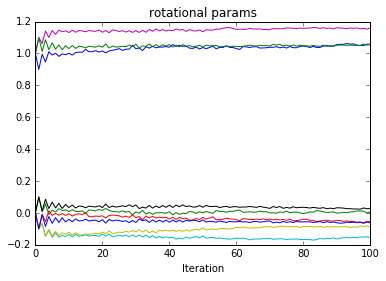

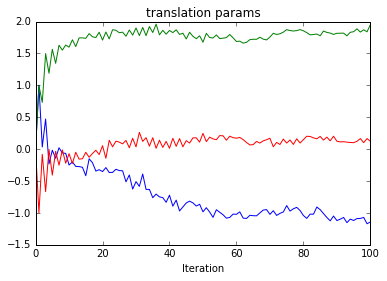

In [47]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.669031181898 -0.669340044016
[[ 1.01617354  0.01549687 -0.01617666 -0.36640471]
 [-0.13265677  1.12983422 -0.11236841  1.72880885]
 [ 0.03372737 -0.04061407  1.03420212  0.13907098]]


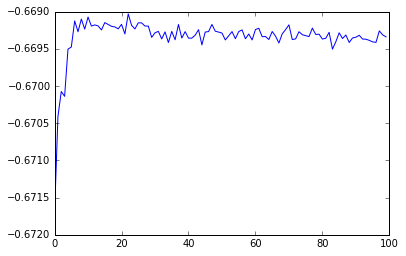

In [48]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [49]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [50]:
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[  1.01617354e+00   1.54968689e-02  -1.61766582e-02   1.53800939e+01]
 [ -1.32656775e-01   1.12983422e+00  -1.12368415e-01  -1.05704841e+02]
 [  3.37273698e-02  -4.06140726e-02   1.03420212e+00  -2.36739182e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [51]:
def transform_volume_one_structure(structure):
    try:
        t = time.time()

#         vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32, prep_id=2, detector_id=detector_id)
        vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32,
                                                volume_type='score')

        volume_m_warped_inbbox, volume_m_warped_bbox_rel2movingvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())
        
        # Note: volume_m_warped_bbox_rel2movingvol is the same as volume_m_warped_bbox_rel2fixedvol.
        volume_m_warped_bbox_rel2fixedvol = volume_m_warped_bbox_rel2movingvol
        
        ######### Save volume ##########
        
        volume_m_warped_fp = \
        DataManager.get_transformed_volume_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_fp)
        bp.pack_ndarray_file(volume_m_warped_inbbox, volume_m_warped_fp)
        upload_to_s3(volume_m_warped_fp)
        
        ############### bbox #############
        volume_m_warped_bbox_fp = \
        DataManager.get_transformed_volume_bbox_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_bbox_fp)
        np.savetxt(volume_m_warped_bbox_fp, volume_m_warped_bbox_rel2fixedvol)
        upload_to_s3(volume_m_warped_bbox_fp)
            
        sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t)) # 3s
    
    except Exception as e:
        sys.stderr.write('Error transforming volume %s: %s.\n' % (structure, e))

In [432]:
# for s in all_known_structures_sided_with_surround:
for s in ['3N_L', 'RMC_L', 'SNR_L', '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200']:
    transform_volume_one_structure(s)

aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt"


Transform: 3.85 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_bbox.txt"


Transform: 2.88 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_bbox.txt"


Transform: 3.16 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt"


Transform: 2.71 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt"


Transform: 3.49 seconds.


aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt"


Transform: 5.32 seconds.


In [433]:
structure = 'SNR_L'

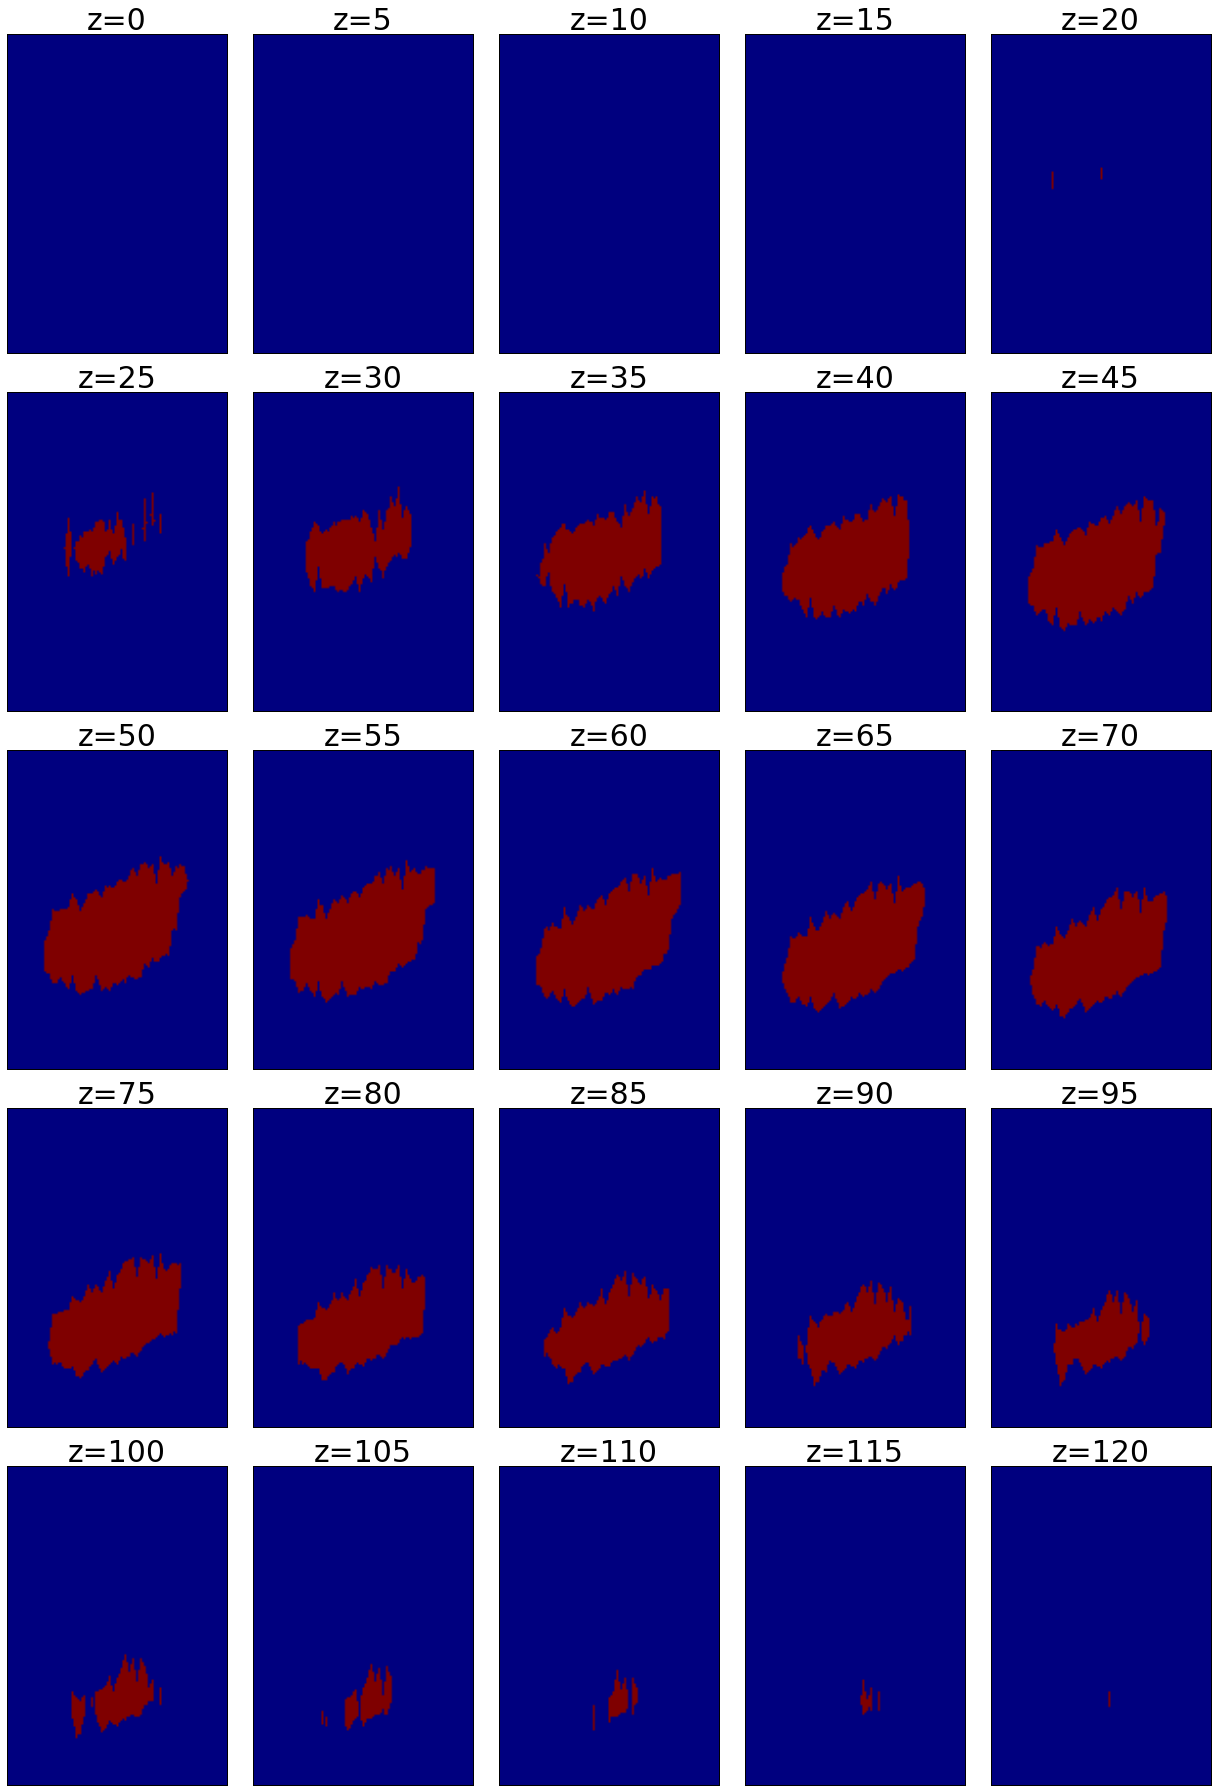

In [434]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [435]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

# volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
# transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

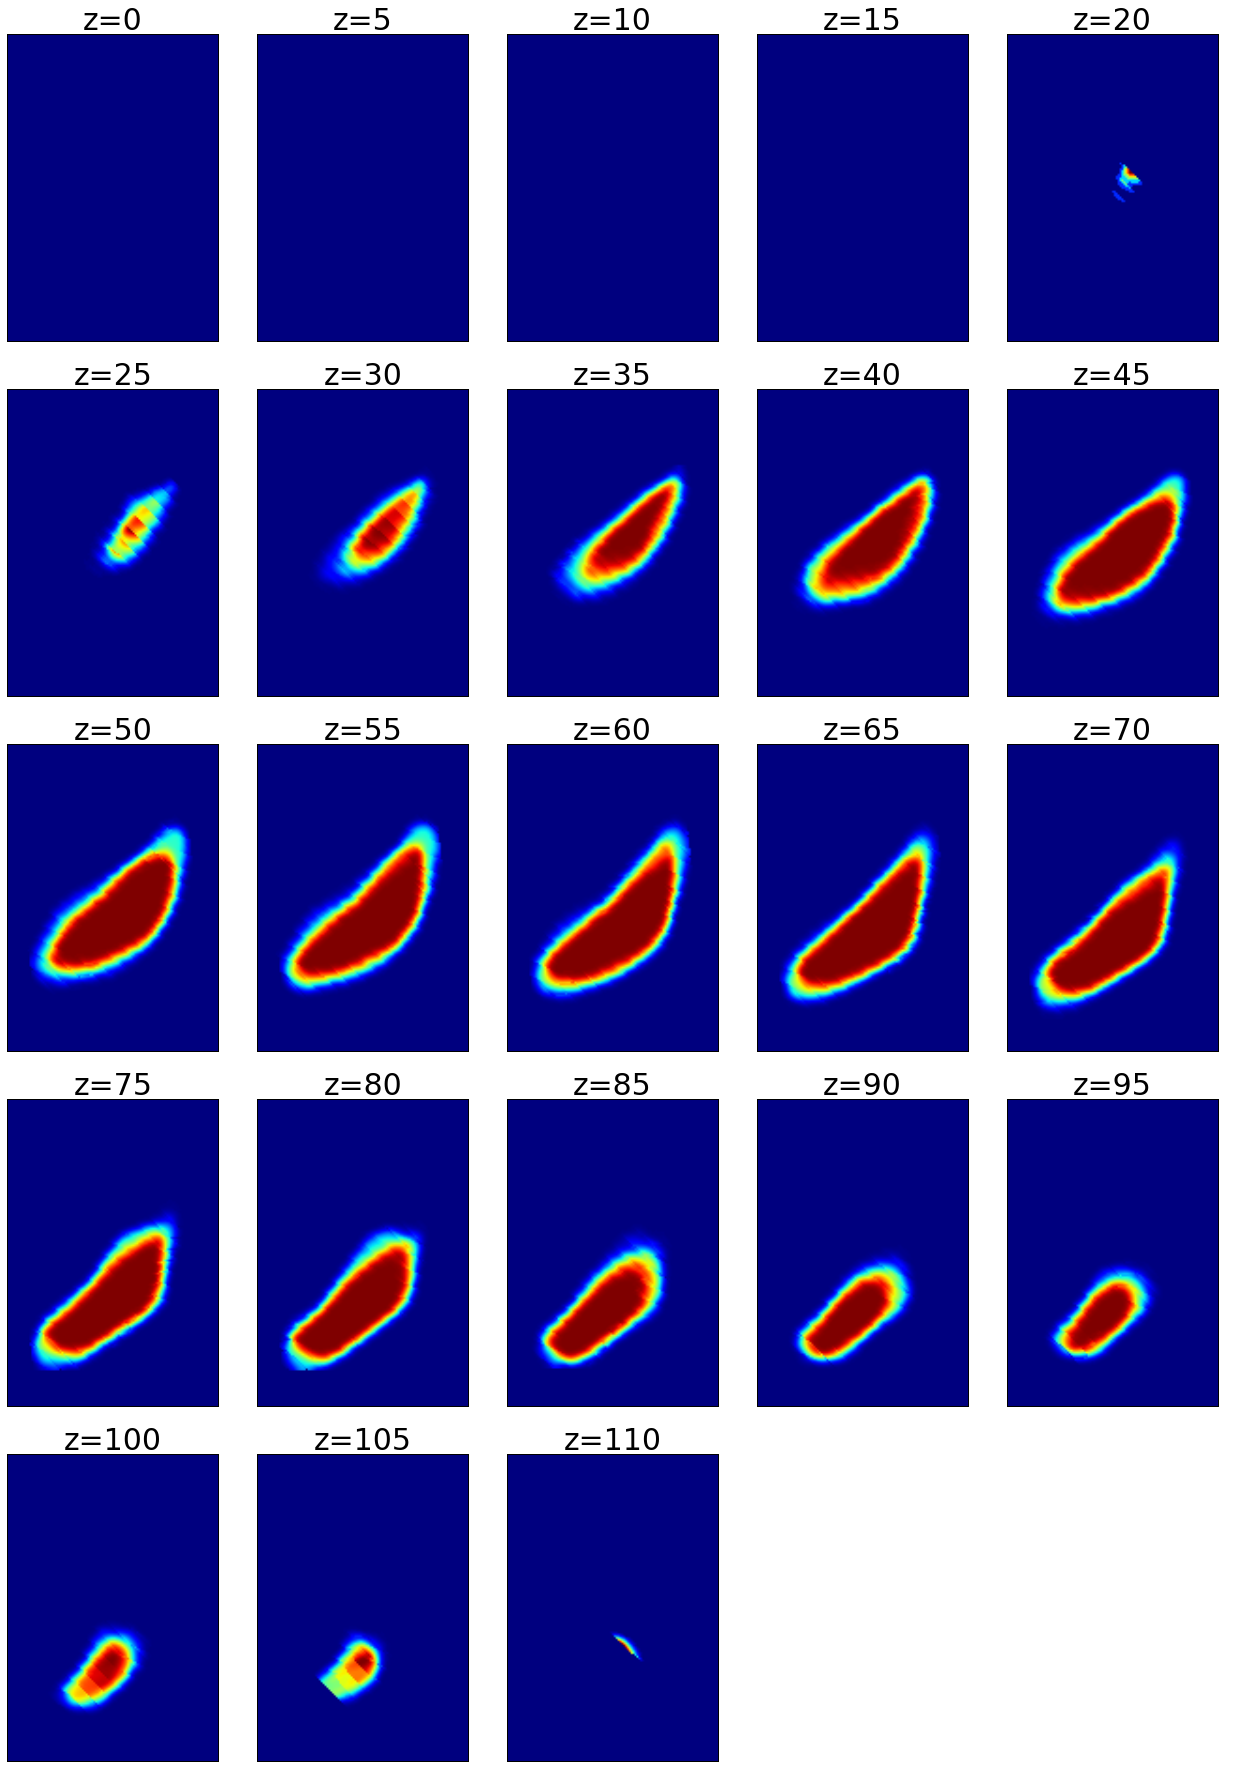

In [436]:
v_m2fg = \
crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2fg, start_level=0)

In [437]:
# Warping all structures.

volume_m2fg = {}
for label_m, vol_m in volume_moving.iteritems():
    
#     volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
#         transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

    volume_m2fg[label_m] = crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

# markers

In [114]:
marker_xyzs_rel2fixedsubj = {}
m = bp.unpack_ndarray_file('/home/yuncong/lauren_data/markers/%(stack)s/%(stack)s_markers_SNR_L.bp' % \
                           {'stack':stack_fixed})
for marker_id, marker_xyz in enumerate(m):
    marker_xyzs_rel2fixedsubj[marker_id] = marker_xyz
    

fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

marker_xyzs_rel2fixedvol = {k: m - fixedvol_bbox_rel2fixedsubj[[0,2,4]]
                                for k, m in marker_xyzs_rel2fixedsubj.iteritems()}

# draw

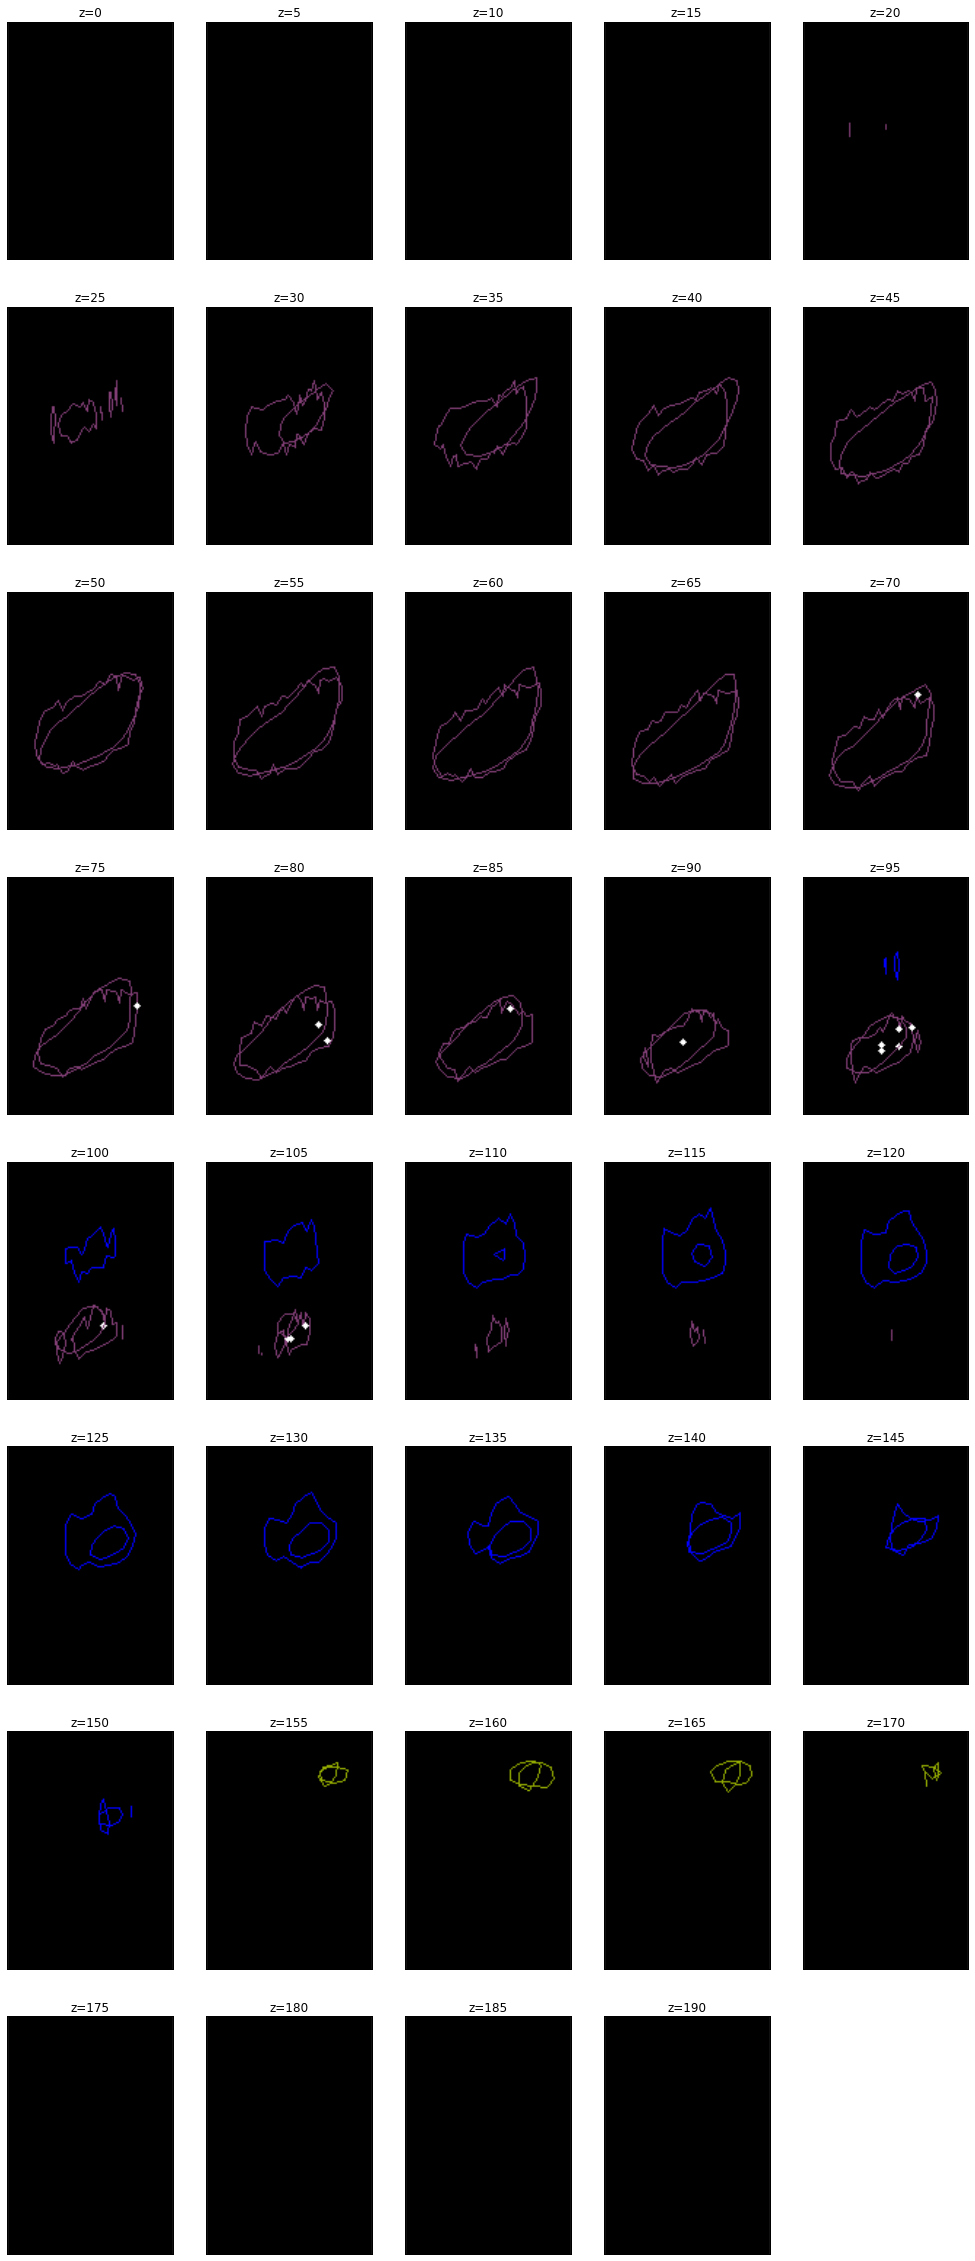

In [439]:
structures_to_draw = [l for l in volume_m2fg.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fg, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

In [440]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsScoreVolume_scoreHistory.bp"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40_down32_annotationAsSc

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [3]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [134]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40'
stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [135]:
warp_setting = 25

In [136]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                                                 24
transform_type                                                                rigid
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                       NaN
std_ty_um                                                                       NaN
std_tz_um                                                                       NaN
std_theta_xy_degree                                                             NaN
surround_weight                                                             inverse
regularization_weight                                                             0
comment                           local reg with surr no grid search; global

In [137]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
# MAX_GRID_SEARCH_ITER_NUM = 30

In [138]:
lr1 = 10
lr2 = 0.1

In [139]:
structure = 'SNR_L'

In [140]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (163, 113, 182)


In [141]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -19   93 1133 1295 5918 6099]


In [142]:
# if include_surround:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                 structures=[structure, convert_to_surround_name(structure, margin='200')])
# else:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                                                  structures=[structure])

if include_surround:
    structures = [structure, convert_to_surround_name(structure, margin='200')]
else:
    structures = [structure]
    
volume_moving_in_bboxrel2fixedvol, volume_moving_bbox_rel2fixedvol, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_transformed_volume_all_known_structures_v2(stack_m=stack_moving, 
                                                         stack_f=stack_fixed,
                                                         warp_setting=24,
                                                         vol_type_f='annotationAsScore',
                                                         vol_type_m='score',
                            structures=[structure, convert_to_surround_name(structure, margin='200')],
                                                        return_label_mappings=True,
                                                         name_or_index_as_key='index',                                                               
                                                            common_shape=True)

print volume_moving_bbox_rel2fixedvol

[  12.  105.   34.  153.    9.  120.]


Prior structure/index map not found. Generating a new one.


In [143]:
# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving_in_bboxrel2fixedvol.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving_in_bboxrel2fixedvol[l] > cutoff), 
                                                  volume_moving_in_bboxrel2fixedvol.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [144]:
label_weights_m

{1: 1.0, 2: 0.4023038520336382}

In [145]:
aligner = Aligner4(volume_fixed, volume_moving_in_bboxrel2fixedvol, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 46.3324167   61.91692575  53.25146209], centroid_f: [ 55.11165633  97.61789349  62.03171572]


In [146]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [147]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.061335 seconds
load gradient 2: 0.064892 seconds
overall: 0.126365 seconds


In [148]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
step: 0.18 seconds
current score: 0.221614
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
step: 0.18 seconds
current score: 0.223564
new_T: [ 1.57023509 -0.05305869  0.10198834]
det: 1.00

iteration 2
step: 0.18 seconds
current score: 0.225188
new_T: [ 1.76412951 -0.44537908  0.46127188]
det: 1.00

iteration 3
step: 0.18 seconds
current score: 0.224780
new_T: [ 1.92270203 -0.60094229  0.50147001]
det: 1.00

iteration 4
step: 0.18 seconds
current score: 0.223986
new_T: [ 2.05927334 -0.5602308   0.40107165]
det: 1.00

iteration 5
step: 0.18 seconds
current score: 0.224457
new_T: [ 2.13106917 -0.6487164   0.42644664]
det: 1.00

iteration 6
step: 0.18 seconds
current score: 0.224535
new_T: [ 2.20397666 -0.58629482  0.37191426]
det: 1.00

iteration 7
step: 0.19 seconds
current score: 0.224867
new_T: [ 2.22701445 -0.62846761  0.40827403]
det: 1.00

iteration 8
step: 0.18 seconds
current score: 0.225105
new_T: [ 2.25623536 -0.5830367   0.38207689]
det: 1.00



step: 0.30 seconds
current score: 0.232622
new_T: [ 1.95993966 -0.13346611  0.59698236]
det: 1.00

iteration 75
step: 0.31 seconds
current score: 0.232698
new_T: [ 1.9572227  -0.13005072  0.59803096]
det: 1.00

iteration 76
step: 0.31 seconds
current score: 0.232765
new_T: [ 1.9550828  -0.12311556  0.59462629]
det: 1.00

iteration 77
step: 0.32 seconds
current score: 0.232812
new_T: [ 1.95311121 -0.12302959  0.58666328]
det: 1.00

iteration 78
step: 0.31 seconds
current score: 0.232860
new_T: [ 1.95242099 -0.13219691  0.5879901 ]
det: 1.00

iteration 79
step: 0.30 seconds
current score: 0.232918
new_T: [ 1.95623996 -0.13524645  0.59131897]
det: 1.00

iteration 80
step: 0.26 seconds
current score: 0.232977
new_T: [ 1.9606452  -0.13264767  0.58979258]
det: 1.00

iteration 81
step: 0.21 seconds
current score: 0.233035
new_T: [ 1.96426326 -0.13339629  0.59427392]
det: 1.00

iteration 82
step: 0.22 seconds
current score: 0.233106
new_T: [ 1.97022381 -0.13282051  0.59529721]
det: 1.00

itera

step: 0.31 seconds
current score: 0.235629
new_T: [ 1.71145687 -0.12165871  0.67210212]
det: 1.00

iteration 148
step: 0.32 seconds
current score: 0.235641
new_T: [ 1.70285455 -0.11279149  0.67200555]
det: 1.00

iteration 149
step: 0.21 seconds
current score: 0.235662
new_T: [ 1.69395667 -0.11923641  0.67629069]
det: 1.00

iteration 150
step: 0.18 seconds
current score: 0.235683
new_T: [ 1.69156729 -0.12055362  0.68201873]
det: 1.00

iteration 151
step: 0.19 seconds
current score: 0.235705
new_T: [ 1.68691838 -0.11593036  0.68841232]
det: 1.00

iteration 152
step: 0.18 seconds
current score: 0.235732
new_T: [ 1.69070442 -0.11350538  0.69212069]
det: 1.00

iteration 153
step: 0.18 seconds
current score: 0.235765
new_T: [ 1.68604895 -0.11212504  0.69943084]
det: 1.00

iteration 154
step: 0.18 seconds
current score: 0.235799
new_T: [ 1.684256   -0.10866178  0.70338187]
det: 1.00

iteration 155
step: 0.18 seconds
current score: 0.235839
new_T: [ 1.68442402 -0.1156337   0.7116672 ]
det: 1.0

step: 0.21 seconds
current score: 0.237200
new_T: [ 1.58715776 -0.1407303   0.80679382]
det: 1.00

iteration 221
step: 0.20 seconds
current score: 0.237210
new_T: [ 1.58091635 -0.14704312  0.80735669]
det: 1.00

iteration 222
step: 0.18 seconds
current score: 0.237224
new_T: [ 1.57596158 -0.15154714  0.80625722]
det: 1.00

iteration 223
step: 0.18 seconds
current score: 0.237252
new_T: [ 1.5748026  -0.15654651  0.80510774]
det: 1.00

iteration 224
step: 0.18 seconds
current score: 0.237262
new_T: [ 1.5732467  -0.15937084  0.80109816]
det: 1.00

iteration 225
step: 0.18 seconds
current score: 0.237280
new_T: [ 1.57147474 -0.16545466  0.79857231]
det: 1.00

iteration 226
step: 0.18 seconds
current score: 0.237299
new_T: [ 1.56706848 -0.16244409  0.79497353]
det: 1.00

iteration 227
step: 0.18 seconds
current score: 0.237310
new_T: [ 1.56227131 -0.16157768  0.79995921]
det: 1.00

iteration 228
step: 0.18 seconds
current score: 0.237324
new_T: [ 1.55584178 -0.15361207  0.80362725]
det: 1.0

step: 0.18 seconds
current score: 0.238068
new_T: [ 1.4187615  -0.14733035  0.94157812]
det: 1.00

iteration 294
step: 0.18 seconds
current score: 0.238086
new_T: [ 1.4163977  -0.15171373  0.94258372]
det: 1.00

iteration 295
step: 0.18 seconds
current score: 0.238093
new_T: [ 1.41558108 -0.15242297  0.94155423]
det: 1.00

iteration 296
step: 0.18 seconds
current score: 0.238100
new_T: [ 1.4127311  -0.15531665  0.9420306 ]
det: 1.00

iteration 297
step: 0.18 seconds
current score: 0.238105
new_T: [ 1.41429521 -0.15992071  0.94505115]
det: 1.00

iteration 298
step: 0.18 seconds
current score: 0.238113
new_T: [ 1.41590326 -0.16117502  0.94175897]
det: 1.00

iteration 299
step: 0.18 seconds
current score: 0.238123
new_T: [ 1.41805294 -0.16972752  0.9434248 ]
det: 1.00

iteration 300
step: 0.18 seconds
current score: 0.238115
new_T: [ 1.41545726 -0.16476225  0.94325217]
det: 1.00

iteration 301
step: 0.18 seconds
current score: 0.238130
new_T: [ 1.41499114 -0.16660123  0.94418353]
det: 1.0

step: 0.21 seconds
current score: 0.238584
new_T: [ 1.40590103 -0.19438475  1.02713926]
det: 1.00

iteration 367
step: 0.21 seconds
current score: 0.238593
new_T: [ 1.40486615 -0.19135913  1.0240576 ]
det: 1.00

iteration 368
step: 0.21 seconds
current score: 0.238596
new_T: [ 1.402317   -0.19398325  1.0256033 ]
det: 1.00

iteration 369
step: 0.21 seconds
current score: 0.238601
new_T: [ 1.40401361 -0.19406873  1.02746035]
det: 1.00

iteration 370
step: 0.21 seconds
current score: 0.238612
new_T: [ 1.40306085 -0.19070916  1.03006482]
det: 1.00

iteration 371
step: 0.21 seconds
current score: 0.238634
new_T: [ 1.40287743 -0.19035185  1.03480144]
det: 1.00

iteration 372
step: 0.21 seconds
current score: 0.238646
new_T: [ 1.40469707 -0.18520658  1.03662982]
det: 1.00

iteration 373
step: 0.21 seconds
current score: 0.238653
new_T: [ 1.40601294 -0.18601018  1.04095445]
det: 1.00

iteration 374
step: 0.21 seconds
current score: 0.238662
new_T: [ 1.40676178 -0.18518028  1.0381635 ]
det: 1.0

step: 0.21 seconds
current score: 0.238960
new_T: [ 1.37823296 -0.19688457  1.12837025]
det: 1.00

iteration 440
step: 0.21 seconds
current score: 0.238970
new_T: [ 1.37792862 -0.19330529  1.12766212]
det: 1.00

iteration 441
step: 0.21 seconds
current score: 0.238974
new_T: [ 1.37693982 -0.19650251  1.13152964]
det: 1.00

iteration 442
step: 0.21 seconds
current score: 0.238974
new_T: [ 1.37560797 -0.19609746  1.13120899]
det: 1.00

iteration 443
step: 0.21 seconds
current score: 0.238967
new_T: [ 1.37565585 -0.19561255  1.13424329]
det: 1.00

iteration 444
step: 0.29 seconds
current score: 0.238968
new_T: [ 1.37457824 -0.19222076  1.13070776]
det: 1.00

iteration 445
step: 0.30 seconds
current score: 0.238970
new_T: [ 1.37344253 -0.19469224  1.13493332]
det: 1.00

iteration 446
step: 0.30 seconds
current score: 0.238972
new_T: [ 1.37087122 -0.19025153  1.13214084]
det: 1.00

iteration 447
step: 0.30 seconds
current score: 0.238979
new_T: [ 1.36878664 -0.19248807  1.13412781]
det: 1.0

step: 0.16 seconds
current score: 0.239168
new_T: [ 1.38176972 -0.21669817  1.16582825]
det: 1.00

iteration 514
step: 0.16 seconds
current score: 0.239166
new_T: [ 1.38209007 -0.21980877  1.17220307]
det: 1.00

iteration 515
step: 0.16 seconds
current score: 0.239171
new_T: [ 1.38509618 -0.21706467  1.17372673]
det: 1.00

iteration 516
step: 0.16 seconds
current score: 0.239171
new_T: [ 1.38585226 -0.21629052  1.17796725]
det: 1.00

iteration 517
step: 0.17 seconds
current score: 0.239170
new_T: [ 1.38873637 -0.21712469  1.1801917 ]
det: 1.00

iteration 518
step: 0.17 seconds
current score: 0.239169
new_T: [ 1.38687387 -0.21982481  1.18257129]
det: 1.00

iteration 519
step: 0.17 seconds
current score: 0.239173
new_T: [ 1.38616071 -0.21750336  1.17996358]
det: 1.00

iteration 520
step: 0.16 seconds
current score: 0.239170
new_T: [ 1.38598407 -0.21903946  1.18192018]
det: 1.00

iteration 521
step: 0.16 seconds
current score: 0.239177
new_T: [ 1.38448665 -0.22061656  1.1818104 ]
det: 1.0

step: 0.18 seconds
current score: 0.239269
new_T: [ 1.3509487  -0.23417637  1.20232237]
det: 1.00

iteration 587
step: 0.19 seconds
current score: 0.239271
new_T: [ 1.34893027 -0.23358096  1.20436184]
det: 1.00

iteration 588
step: 0.19 seconds
current score: 0.239273
new_T: [ 1.34624321 -0.23689906  1.20804801]
det: 1.00

iteration 589
step: 0.21 seconds
current score: 0.239268
new_T: [ 1.34776499 -0.23027196  1.20517914]
det: 1.00

iteration 590
step: 0.19 seconds
current score: 0.239279
new_T: [ 1.34639089 -0.23464295  1.21153556]
det: 1.00

iteration 591
step: 0.18 seconds
current score: 0.239276
new_T: [ 1.34645083 -0.231492    1.21269228]
det: 1.00

iteration 592
step: 0.18 seconds
current score: 0.239276
new_T: [ 1.34544052 -0.23023214  1.21503353]
det: 1.00

iteration 593
step: 0.18 seconds
current score: 0.239279
new_T: [ 1.34435793 -0.2276122   1.21611326]
det: 1.00

iteration 594
step: 0.18 seconds
current score: 0.239282
new_T: [ 1.34419397 -0.22609965  1.21925755]
det: 1.0

step: 0.32 seconds
current score: 0.239369
new_T: [ 1.32114439 -0.25407986  1.24918994]
det: 1.00

iteration 660
step: 0.31 seconds
current score: 0.239370
new_T: [ 1.31993687 -0.25529321  1.24972882]
det: 1.00

iteration 661
step: 0.33 seconds
current score: 0.239367
new_T: [ 1.32031901 -0.25661588  1.25010014]
det: 1.00

iteration 662
step: 0.31 seconds
current score: 0.239372
new_T: [ 1.31865414 -0.25782701  1.2503699 ]
det: 1.00

iteration 663
step: 0.31 seconds
current score: 0.239367
new_T: [ 1.31966979 -0.25972018  1.24695683]
det: 1.00

iteration 664
step: 0.31 seconds
current score: 0.239369
new_T: [ 1.31601147 -0.2628281   1.24300816]
det: 1.00

iteration 665
step: 0.31 seconds
current score: 0.239365
new_T: [ 1.31460488 -0.26179873  1.23978424]
det: 1.00

iteration 666
step: 0.31 seconds
current score: 0.239367
new_T: [ 1.31514295 -0.26474118  1.24002884]
det: 1.00

iteration 667
step: 0.31 seconds
current score: 0.239367
new_T: [ 1.31379809 -0.26497684  1.24071536]
det: 1.0

step: 0.18 seconds
current score: 0.239440
new_T: [ 1.30142232 -0.25325515  1.29722221]
det: 1.00

iteration 734
step: 0.18 seconds
current score: 0.239446
new_T: [ 1.30189266 -0.25405358  1.29767477]
det: 1.00

iteration 735
step: 0.18 seconds
current score: 0.239448
new_T: [ 1.30397758 -0.25334483  1.29970173]
det: 1.00

iteration 736
step: 0.18 seconds
current score: 0.239450
new_T: [ 1.30300443 -0.25150081  1.29853302]
det: 1.00

iteration 737
step: 0.19 seconds
current score: 0.239448
new_T: [ 1.30431431 -0.25105096  1.30277593]
det: 1.00

iteration 738
step: 0.18 seconds
current score: 0.239450
new_T: [ 1.30563582 -0.24948327  1.30522334]
det: 1.00

iteration 739
step: 0.19 seconds
current score: 0.239452
new_T: [ 1.30705153 -0.2480204   1.30804825]
det: 1.00

iteration 740
step: 0.38 seconds
current score: 0.239451
new_T: [ 1.30713961 -0.24881622  1.30621288]
det: 1.00

iteration 741
step: 0.38 seconds
current score: 0.239448
new_T: [ 1.30674295 -0.24991489  1.30871759]
det: 1.0

step: 0.18 seconds
current score: 0.239491
new_T: [ 1.28794316 -0.25548296  1.33476866]
det: 1.00

iteration 808
step: 0.18 seconds
current score: 0.239491
new_T: [ 1.28945604 -0.25583212  1.33571279]
det: 1.00

iteration 809
step: 0.18 seconds
current score: 0.239492
new_T: [ 1.29030463 -0.25411127  1.33656242]
det: 1.00

iteration 810
step: 0.19 seconds
current score: 0.239491
new_T: [ 1.29042696 -0.2520419   1.33872082]
det: 1.00

iteration 811
step: 0.19 seconds
current score: 0.239489
new_T: [ 1.29111805 -0.25275358  1.34052905]
det: 1.00

iteration 812
step: 0.18 seconds
current score: 0.239492
new_T: [ 1.29154834 -0.25388291  1.34240071]
det: 1.00

iteration 813
step: 0.18 seconds
current score: 0.239492
new_T: [ 1.28973288 -0.25371574  1.34445665]
det: 1.00

iteration 814
step: 0.18 seconds
current score: 0.239494
new_T: [ 1.28926839 -0.25364607  1.34592761]
det: 1.00

iteration 815
step: 0.19 seconds
current score: 0.239490
new_T: [ 1.28911067 -0.25457678  1.34811375]
det: 1.0

step: 0.19 seconds
current score: 0.239502
new_T: [ 1.29073673 -0.29203942  1.33070242]
det: 1.00

iteration 882
step: 0.19 seconds
current score: 0.239507
new_T: [ 1.29336641 -0.29241134  1.32745895]
det: 1.00

iteration 883
step: 0.19 seconds
current score: 0.239503
new_T: [ 1.29228729 -0.2931508   1.32624214]
det: 1.00

iteration 884
step: 0.19 seconds
current score: 0.239504
new_T: [ 1.29268518 -0.29435874  1.3284295 ]
det: 1.00

iteration 885
step: 0.19 seconds
current score: 0.239504
new_T: [ 1.29345637 -0.29479421  1.32941183]
det: 1.00

iteration 886
step: 0.19 seconds
current score: 0.239505
new_T: [ 1.29388083 -0.2920326   1.3288038 ]
det: 1.00

iteration 887
step: 0.18 seconds
current score: 0.239505
new_T: [ 1.29440144 -0.29256162  1.33145434]
det: 1.00

iteration 888
step: 0.19 seconds
current score: 0.239501
new_T: [ 1.29454946 -0.29247146  1.3328047 ]
det: 1.00

iteration 889
step: 0.30 seconds
current score: 0.239501
new_T: [ 1.2944546  -0.2933488   1.33367219]
det: 1.0

step: 0.18 seconds
current score: 0.239528
new_T: [ 1.29422049 -0.3147557   1.31011525]
det: 1.00

iteration 956
step: 0.26 seconds
current score: 0.239528
new_T: [ 1.29450714 -0.31228249  1.31132505]
det: 1.00

iteration 957
step: 0.31 seconds
current score: 0.239528
new_T: [ 1.29443271 -0.31380309  1.31472848]
det: 1.00

iteration 958
step: 0.30 seconds
current score: 0.239530
new_T: [ 1.29449122 -0.31215463  1.31100599]
det: 1.00

iteration 959
step: 0.30 seconds
current score: 0.239520
new_T: [ 1.29468338 -0.3152408   1.31425617]
det: 1.00

iteration 960
step: 0.30 seconds
current score: 0.239523
new_T: [ 1.29618977 -0.31445275  1.31137279]
det: 1.00

iteration 961
step: 0.31 seconds
current score: 0.239520
new_T: [ 1.29501662 -0.31600046  1.31432779]
det: 1.00

iteration 962
step: 0.31 seconds
current score: 0.239521
new_T: [ 1.29761178 -0.31534794  1.31297658]
det: 1.00

iteration 963
step: 0.30 seconds
current score: 0.239522
new_T: [ 1.29644838 -0.31836641  1.31458897]
det: 1.0

step: 0.30 seconds
current score: 0.239529
new_T: [ 1.31709164 -0.31159503  1.3183506 ]
det: 1.00

iteration 1029
step: 0.31 seconds
current score: 0.239524
new_T: [ 1.31925843 -0.31140379  1.3200462 ]
det: 1.00

iteration 1030
step: 0.31 seconds
current score: 0.239532
new_T: [ 1.31972694 -0.31143473  1.32071041]
det: 1.00

iteration 1031
step: 0.34 seconds
current score: 0.239532
new_T: [ 1.32059492 -0.31060791  1.31981467]
det: 1.00

iteration 1032
step: 0.32 seconds
current score: 0.239534
new_T: [ 1.32071087 -0.31384968  1.32192957]
det: 1.00

iteration 1033
step: 0.32 seconds
current score: 0.239526
new_T: [ 1.32165454 -0.31211473  1.32068901]
det: 1.00

iteration 1034
step: 0.34 seconds
current score: 0.239533
new_T: [ 1.32166378 -0.31103838  1.32233649]
det: 1.00

iteration 1035
step: 0.31 seconds
current score: 0.239533
new_T: [ 1.32048675 -0.31143941  1.32338089]
det: 1.00

iteration 1036
step: 0.32 seconds
current score: 0.239529
new_T: [ 1.32048157 -0.31009885  1.32168726]


step: 0.31 seconds
current score: 0.239527
new_T: [ 1.31844263 -0.32090497  1.32961751]
det: 1.00

iteration 1101
step: 0.31 seconds
current score: 0.239524
new_T: [ 1.31920253 -0.32390845  1.33245793]
det: 1.00

iteration 1102
step: 0.31 seconds
current score: 0.239521
new_T: [ 1.31844951 -0.32303259  1.33145811]
det: 1.00

iteration 1103
step: 0.32 seconds
current score: 0.239519
new_T: [ 1.31689011 -0.32395163  1.33152995]
det: 1.00

iteration 1104
step: 0.34 seconds
current score: 0.239525
new_T: [ 1.31684155 -0.32592513  1.33170041]
det: 1.00

iteration 1105
step: 0.26 seconds
current score: 0.239525
new_T: [ 1.31676222 -0.32429176  1.33073957]
det: 1.00

iteration 1106
step: 0.19 seconds
current score: 0.239524
new_T: [ 1.3168585  -0.32415754  1.33135211]
det: 1.00

iteration 1107
step: 0.19 seconds
current score: 0.239525
new_T: [ 1.31603751 -0.32502483  1.33112607]
det: 1.00

iteration 1108
step: 0.19 seconds
current score: 0.239526
new_T: [ 1.31635281 -0.3251307   1.3313083 ]


step: 0.32 seconds
current score: 0.239535
new_T: [ 1.33320903 -0.34158718  1.31886289]
det: 1.00

iteration 1173
step: 0.26 seconds
current score: 0.239532
new_T: [ 1.33369851 -0.34120117  1.31965726]
det: 1.00

iteration 1174
step: 0.21 seconds
current score: 0.239535
new_T: [ 1.33450422 -0.34289656  1.31848849]
det: 1.00

iteration 1175
step: 0.19 seconds
current score: 0.239536
new_T: [ 1.33385996 -0.34315873  1.32002518]
det: 1.00

iteration 1176
step: 0.18 seconds
current score: 0.239537
new_T: [ 1.3328603  -0.34363925  1.31883695]
det: 1.00

iteration 1177
step: 0.18 seconds
current score: 0.239536
new_T: [ 1.33267803 -0.34452293  1.31853754]
det: 1.00

iteration 1178
step: 0.18 seconds
current score: 0.239536
new_T: [ 1.3326506  -0.34421836  1.31835159]
det: 1.00

iteration 1179
step: 0.19 seconds
current score: 0.239538
new_T: [ 1.33170116 -0.345313    1.31962699]
det: 1.00

iteration 1180
step: 0.18 seconds
current score: 0.239537
new_T: [ 1.33191198 -0.34157116  1.31701554]


step: 0.18 seconds
current score: 0.239517
new_T: [ 1.32020053 -0.34586044  1.32170327]
det: 1.00

iteration 1245
step: 0.18 seconds
current score: 0.239516
new_T: [ 1.32008979 -0.34595106  1.32066891]
det: 1.00

iteration 1246
step: 0.18 seconds
current score: 0.239518
new_T: [ 1.32155361 -0.34537628  1.32274092]
det: 1.00

iteration 1247
step: 0.19 seconds
current score: 0.239517
new_T: [ 1.32116283 -0.34601879  1.32294082]
det: 1.00

iteration 1248
step: 0.19 seconds
current score: 0.239512
new_T: [ 1.32151868 -0.34550964  1.32165656]
det: 1.00

iteration 1249
step: 0.18 seconds
current score: 0.239516
new_T: [ 1.32159325 -0.34518972  1.32246225]
det: 1.00

iteration 1250
step: 0.18 seconds
current score: 0.239516
new_T: [ 1.32202385 -0.34524629  1.32213233]
det: 1.00

iteration 1251
step: 0.18 seconds
current score: 0.239523
new_T: [ 1.32166613 -0.3452599   1.32244098]
det: 1.00

iteration 1252
step: 0.18 seconds
current score: 0.239521
new_T: [ 1.32265917 -0.34462858  1.32156369]


step: 0.18 seconds
current score: 0.239528
new_T: [ 1.32365912 -0.34623339  1.31851887]
det: 1.00

iteration 1317
step: 0.18 seconds
current score: 0.239532
new_T: [ 1.32262734 -0.34709729  1.31665899]
det: 1.00

iteration 1318
step: 0.18 seconds
current score: 0.239537
new_T: [ 1.32145554 -0.34987034  1.31857096]
det: 1.00

iteration 1319
step: 0.18 seconds
current score: 0.239539
new_T: [ 1.32328247 -0.34949334  1.31937396]
det: 1.00

iteration 1320
step: 0.18 seconds
current score: 0.239532
new_T: [ 1.32276729 -0.34707404  1.31739319]
det: 1.00

iteration 1321
step: 0.18 seconds
current score: 0.239535
new_T: [ 1.32160633 -0.35017296  1.31871149]
det: 1.00

iteration 1322
step: 0.18 seconds
current score: 0.239535
new_T: [ 1.32227185 -0.34708242  1.31694093]
det: 1.00

iteration 1323
step: 0.18 seconds
current score: 0.239536
new_T: [ 1.32175821 -0.3507951   1.31832087]
det: 1.00

iteration 1324
step: 0.18 seconds
current score: 0.239534
new_T: [ 1.32179477 -0.34755106  1.31792993]


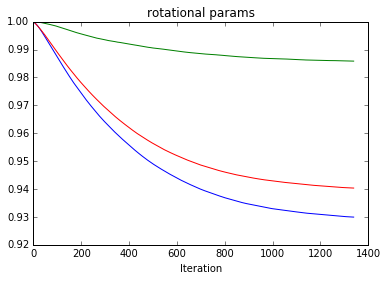

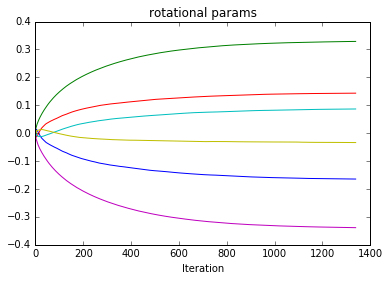

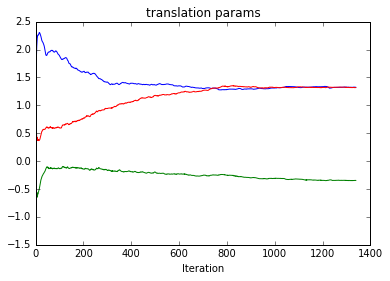

In [149]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.239543524468 0.23953605519
[[ 0.93081786 -0.16283367  0.3272053   1.33951583]
 [ 0.14240377  0.98609786  0.08562808 -0.34617805]
 [-0.33659958 -0.03310888  0.94106563  1.32095412]]


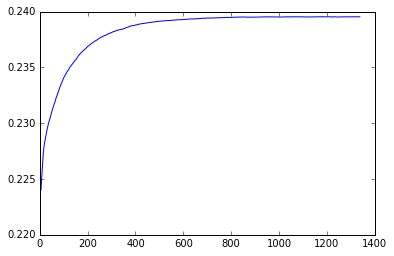

In [150]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

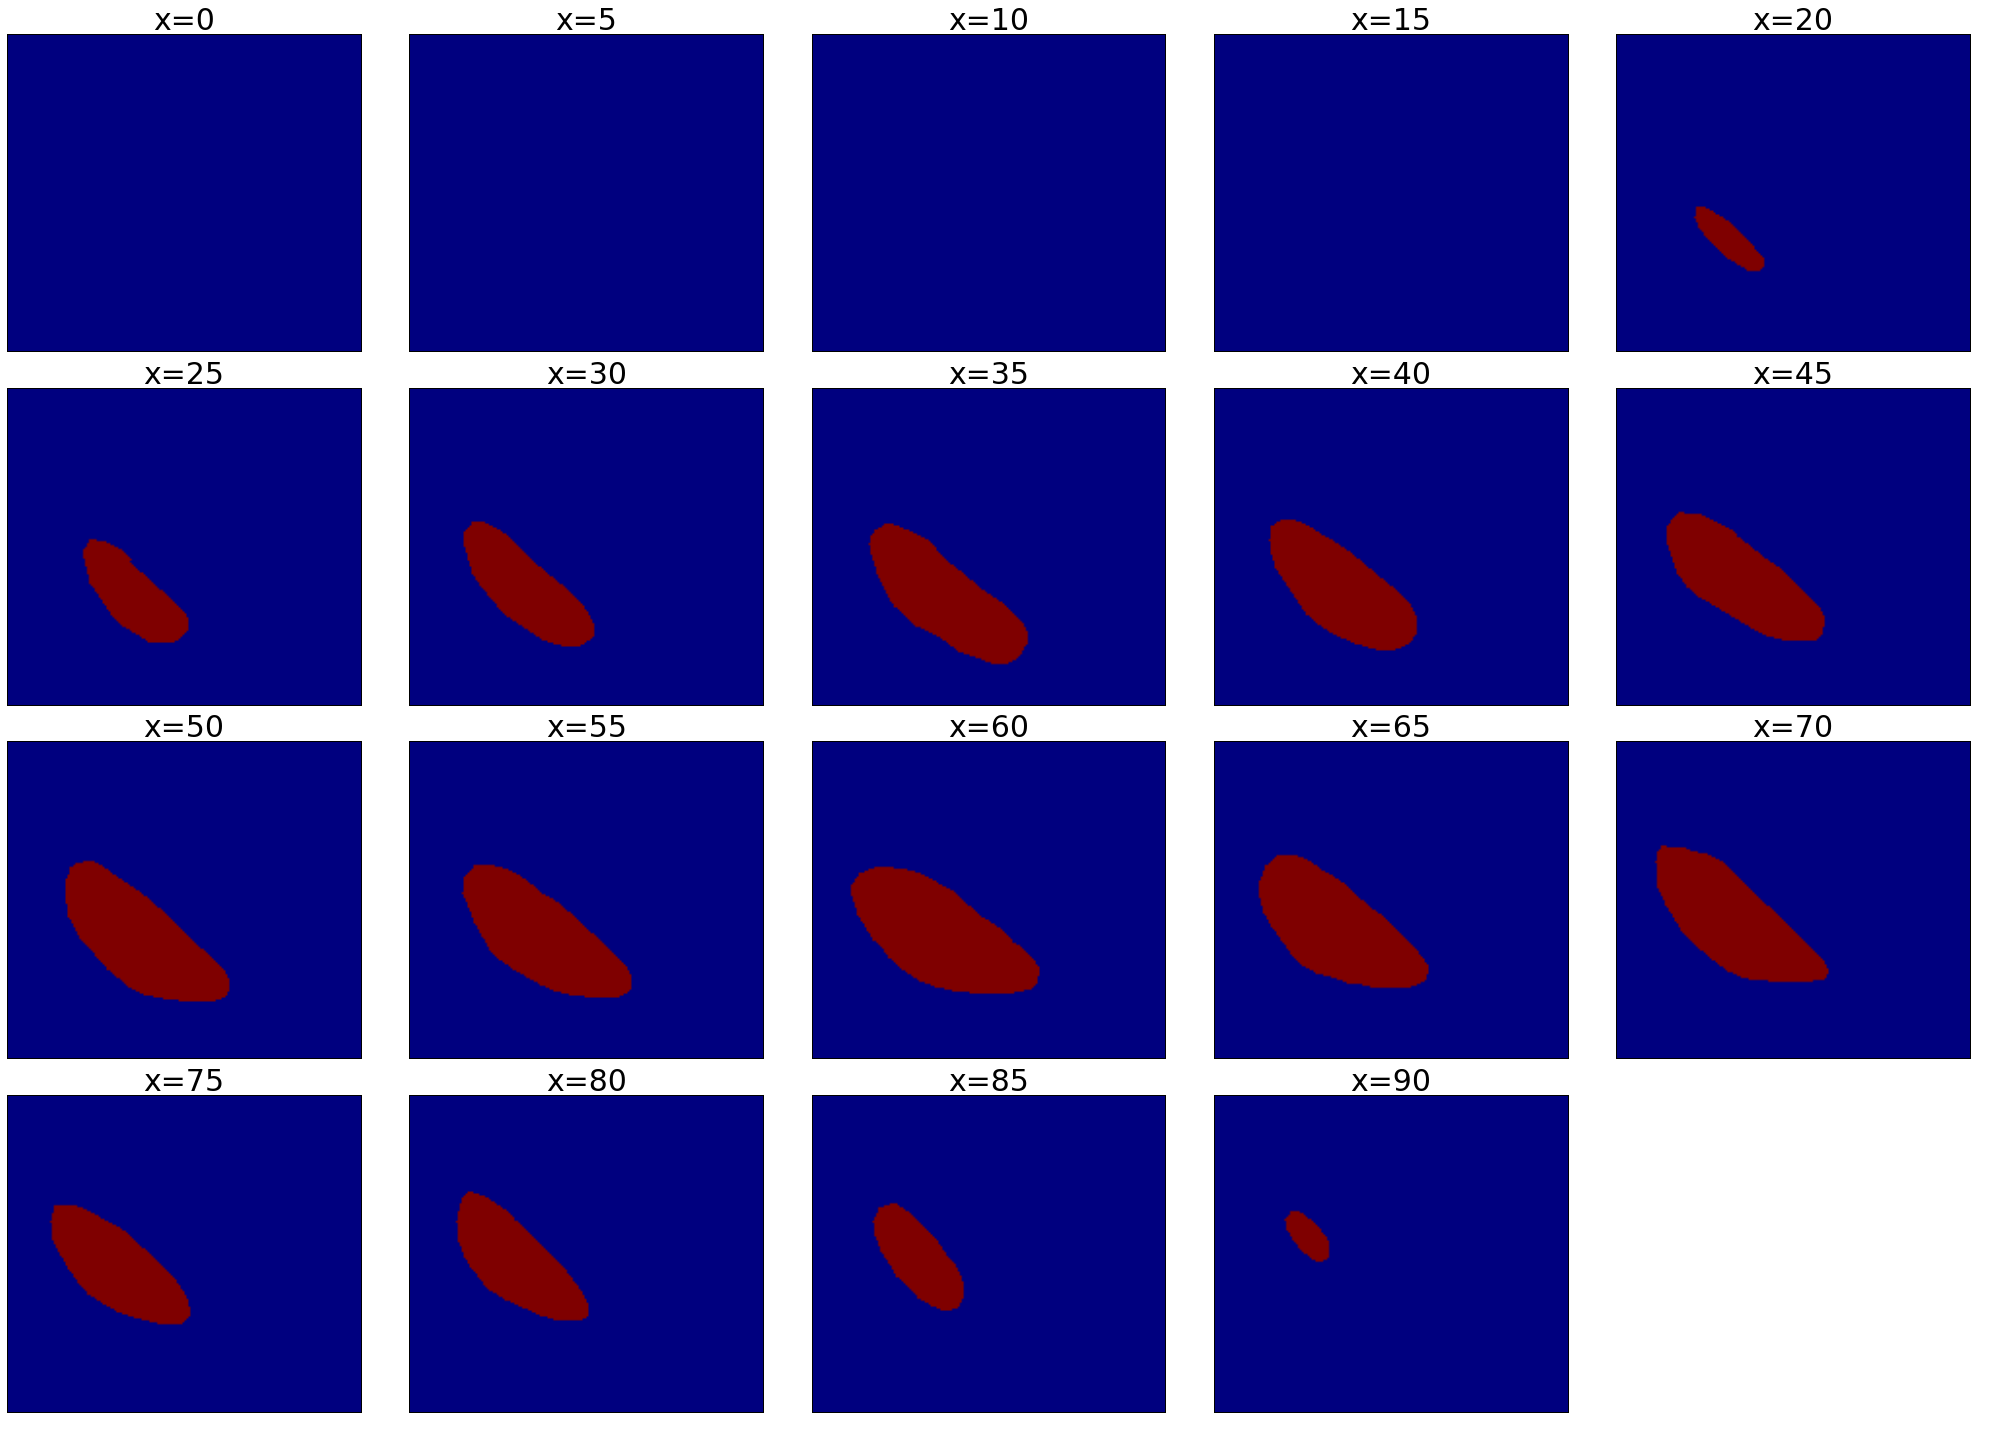

In [151]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [152]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m='atlasV5', warp_setting=24)
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[  9.36063195e-01   1.46600210e-01  -5.09944914e-02  -1.60226346e+01]
 [  9.53245342e-02   1.00190201e+00  -1.77646349e-01  -9.97328293e+01]
 [  2.93864987e-02  -2.71595715e-02   1.01754352e+00  -2.64794493e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [153]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [154]:
L = consolidate(params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)
print L

[[  0.93081786  -0.16283367   0.3272053    5.98213128]
 [  0.14240377   0.98609786   0.08562808  25.05783576]
 [ -0.33659958  -0.03310888   0.94106563  30.88502069]
 [  0.           0.           0.           1.        ]]


In [155]:
Q_movingvol2fixedvol = np.dot(L, G_movingvol2fixedvol - np.column_stack([np.zeros((4,3)), 
                                                  np.r_[volume_moving_bbox_rel2fixedvol[[0,2,4]], 0]]))
print Q_movingvol2fixedvol

# This is shared by all structures.
fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='annotationAsScore', structure='SNR_L',
                                      relative_to_uncropped=True)
print fixedvol_bbox_rel2fixedsubj

Q_movingvol2fixedsubj = Q_movingvol2fixedvol + np.column_stack([np.zeros((4,3)),
                                                                np.r_[fixedvol_bbox_rel2fixedsubj[[0,2,4]], 0]])
print Q_movingvol2fixedsubj

[[  8.65397714e-01  -3.55720475e-02   3.14405853e-01  -9.93469327e+00]
 [  2.29814561e-01   1.00652423e+00  -9.53081957e-02  -1.13844388e+02]
 [ -2.90579941e-01  -1.08076358e-01   9.80621634e-01   1.13566810e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[ -19   93 1133 1295 5918 6099]
[[  8.65397714e-01  -3.55720475e-02   3.14405853e-01  -2.89346933e+01]
 [  2.29814561e-01   1.00652423e+00  -9.53081957e-02   1.01915561e+03]
 [ -2.90579941e-01  -1.08076358e-01   9.80621634e-01   5.92935668e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [156]:
# pts_rel2fixedsubj = np.array([[   28.5326087 ,   801.51154891,  1332.56657609]])
# pts_rel2movingvol = np.dot(np.linalg.inv(Q_movingvol2fixedsubj), 
#              np.column_stack([pts_rel2fixedsubj, np.ones((len(pts_rel2fixedsubj),))]).T).T[:, :3]

# print pts_rel2movingvol

In [157]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving_in_bboxrel2fixedvol[structure_to_label_moving[structure]]

volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

print volume_m2fl_bbox_rel2fixedvol

(8, 99, 41, 144, 11, 116)


Interpolating/filling sparse volume: 0.09 seconds.


In [158]:
# x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
# sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

# plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Volume');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size x');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size y');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size z');
# plt.show();

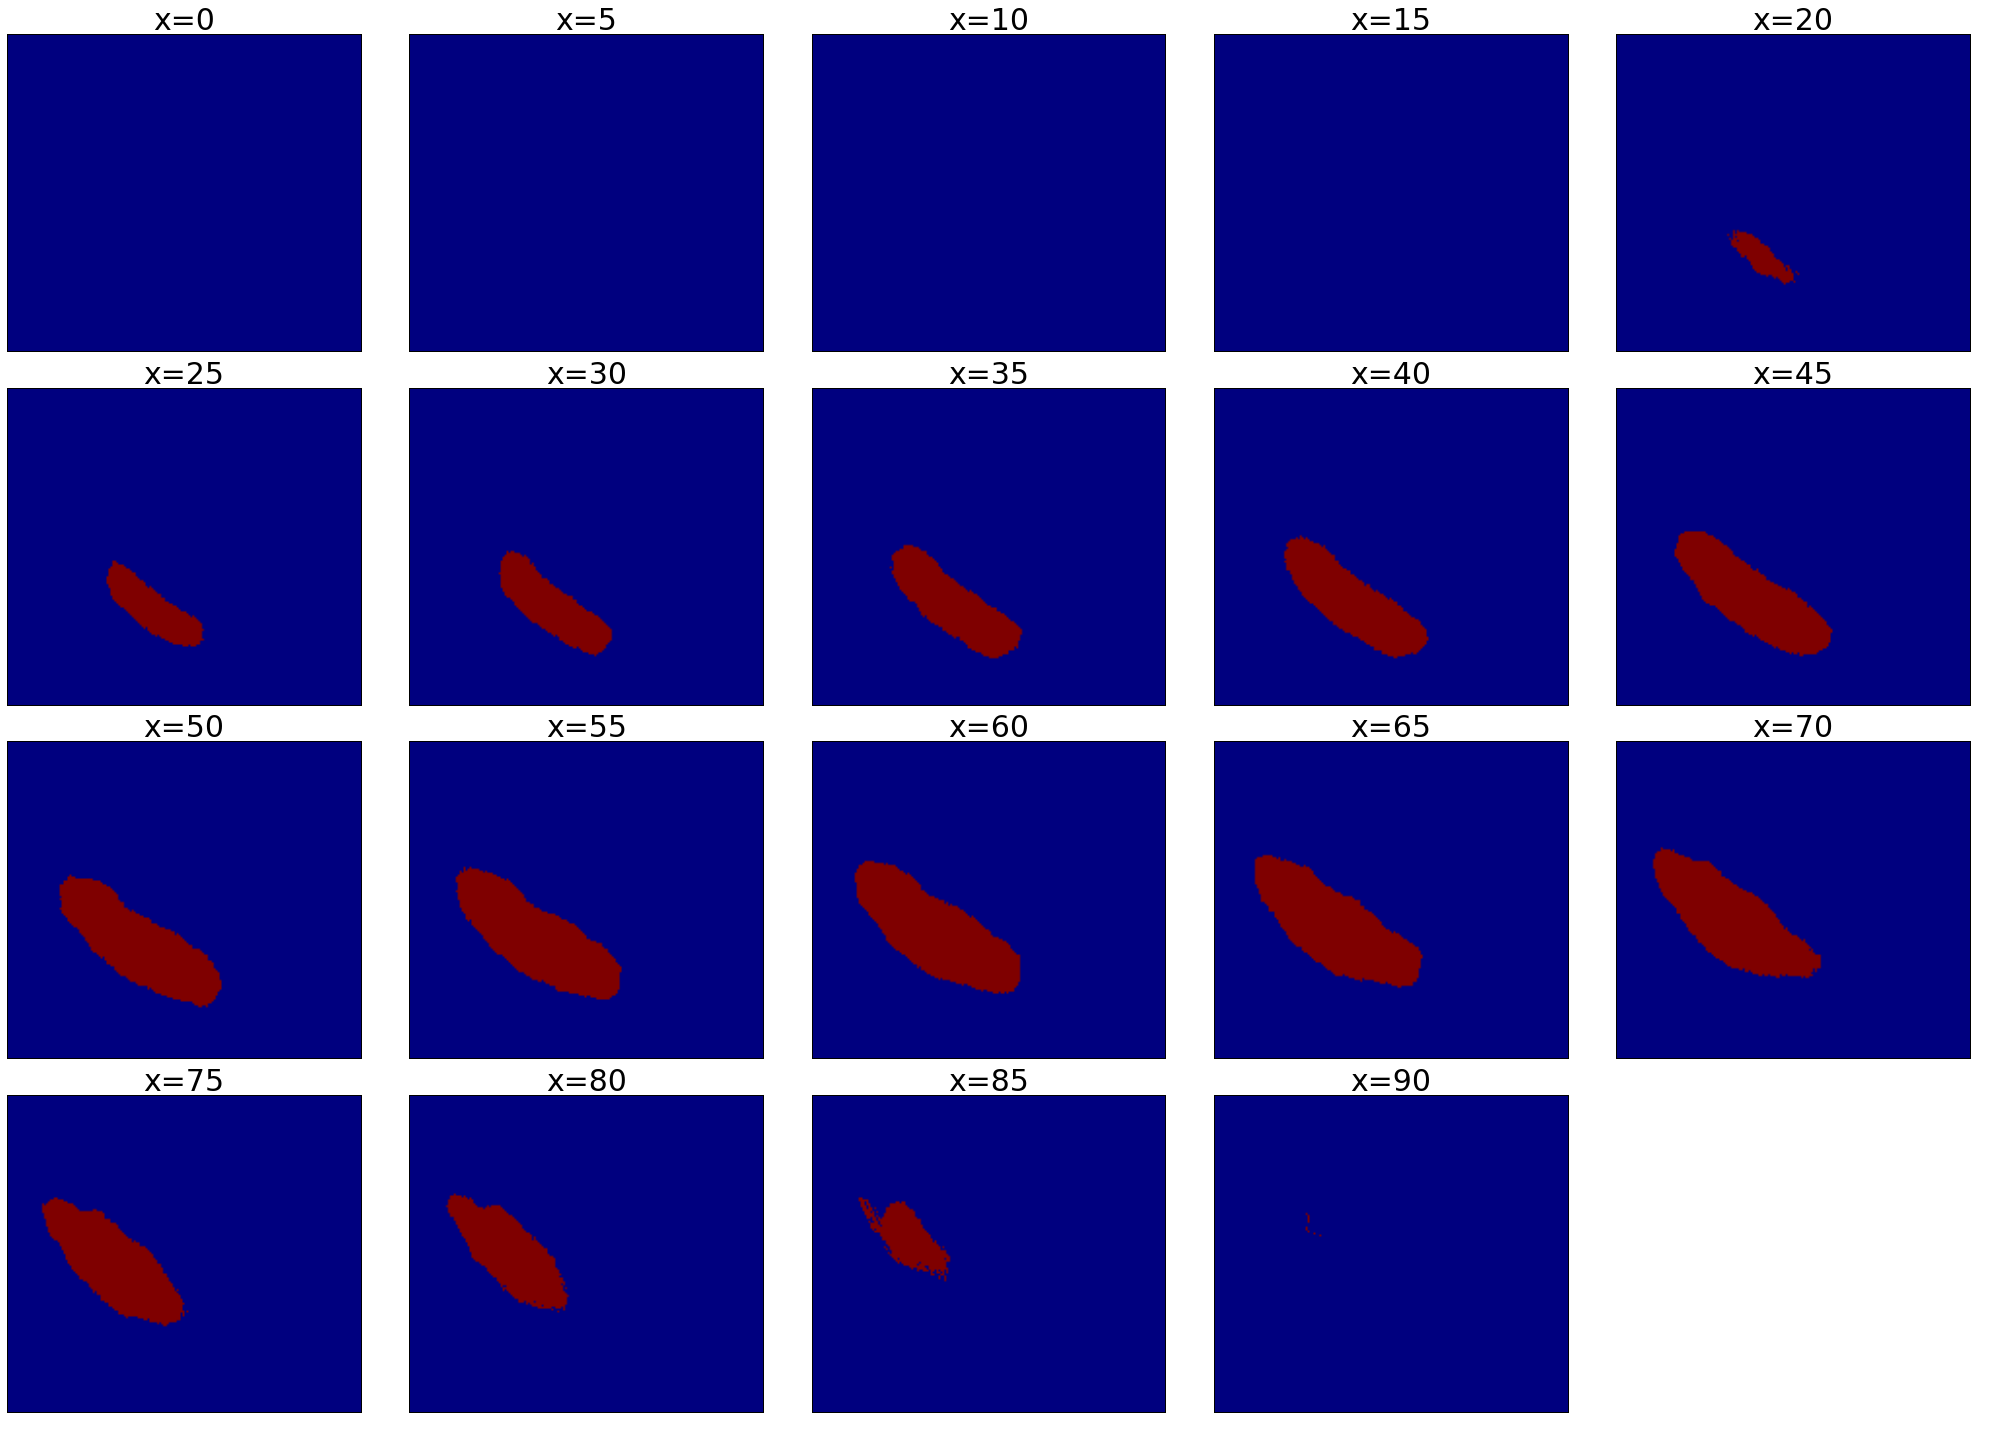

In [159]:
display_volume_sections(crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [160]:
# Warping all atlas structures.

volume_m2fl = {}
for label_m, vol_m in volume_moving_in_bboxrel2fixedvol.iteritems():
    
    volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
    transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fl[label_m] = crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

Interpolating/filling sparse volume: 0.10 seconds.
Interpolating/filling sparse volume: 0.12 seconds.


# draw

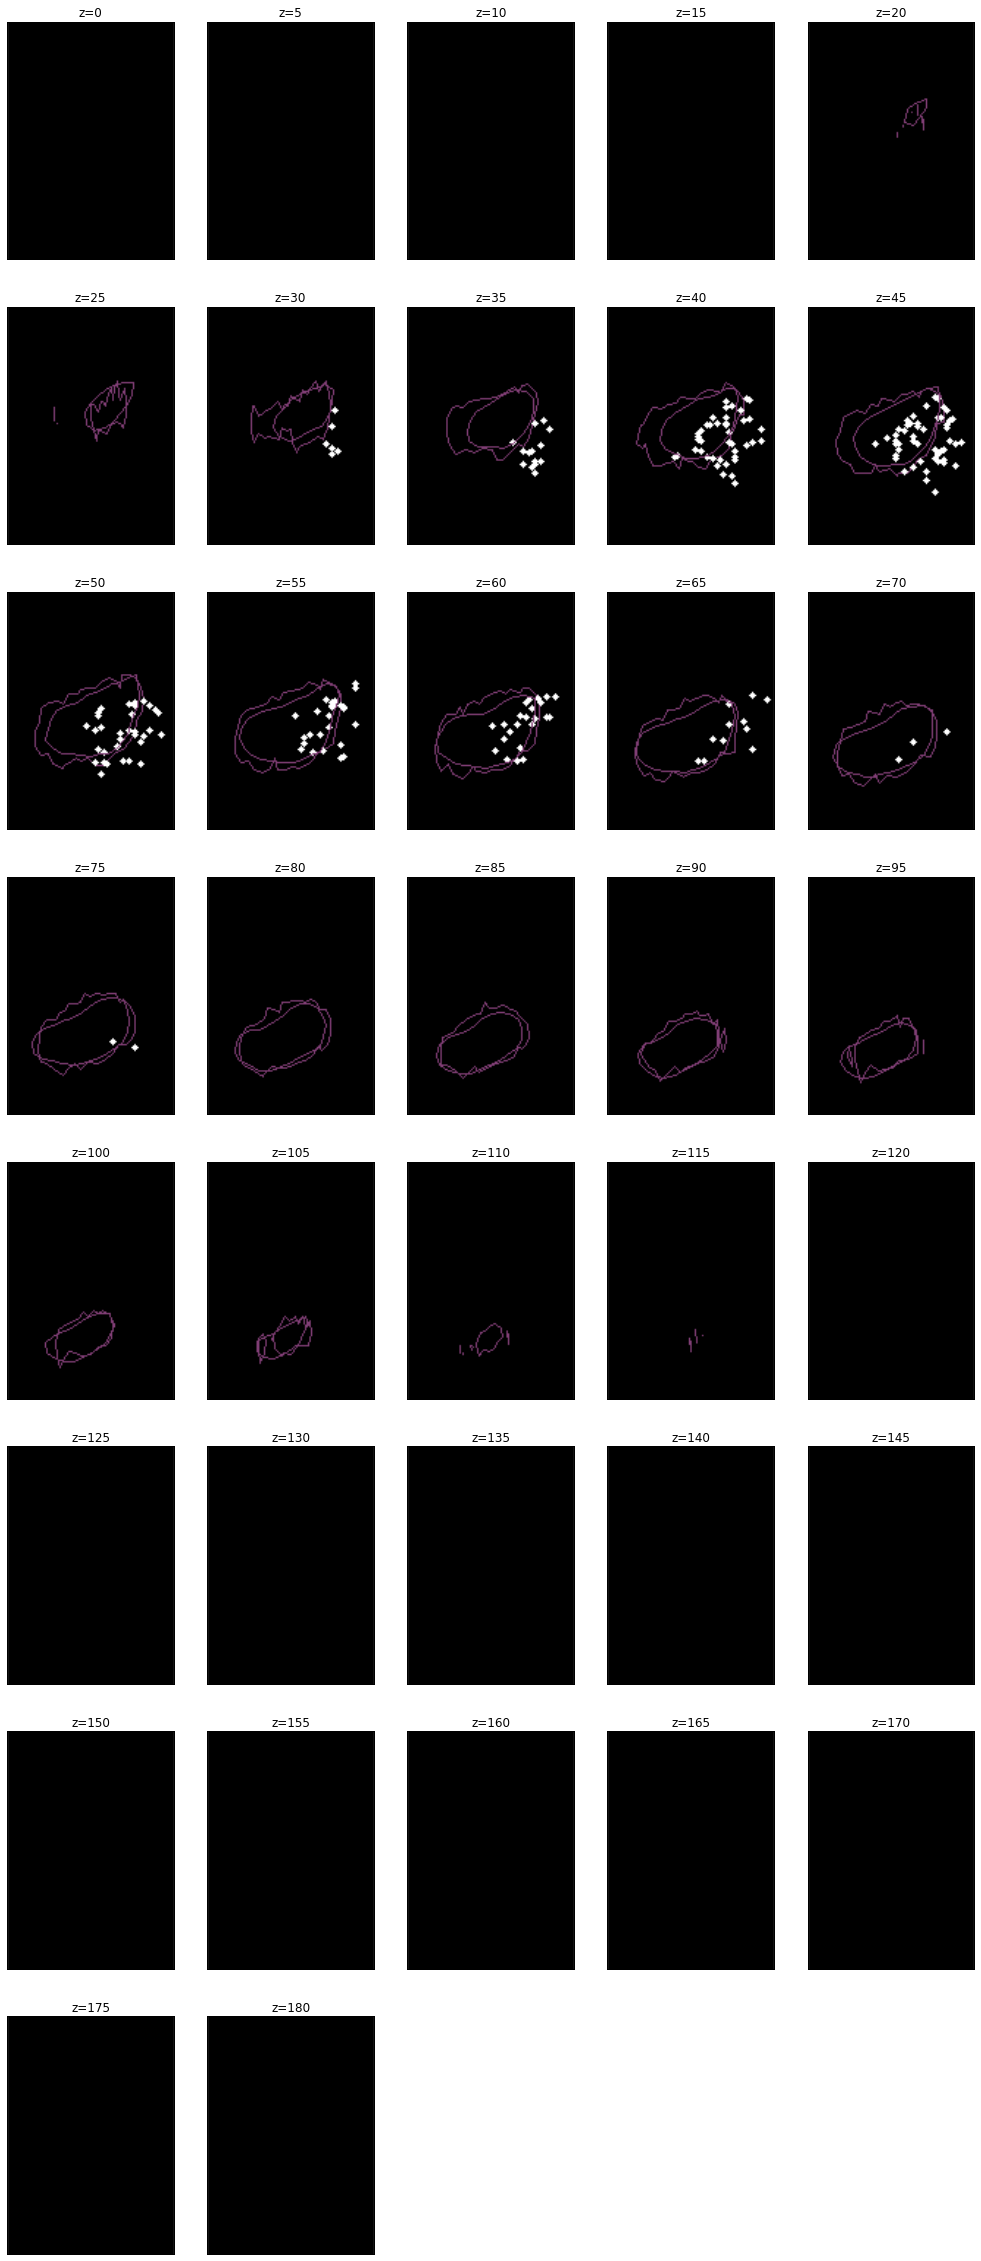

In [161]:
structures_to_draw = [l for l in volume_m2fl.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fl, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values()))

In [162]:
launch_vtk([actor_mesh(volume_to_polydata(volume_m2fl[1], num_simplify_iter=3, smooth=True),
                       wireframe=True, color=(0,0,0)),
            actor_mesh(volume_to_polydata(volume_fixed[1], num_simplify_iter=3, smooth=True), 
                       wireframe=True, color=(0,1,0)),
           ])

marching cube: 1.00 seconds
mesh_to_polydata: 0.07 seconds
simplify 0 @ 28277: 0.45 seconds
simplify 1 @ 5661: 0.52 seconds
simplify 2 @ 1133: 0.12 seconds
marching cube: 0.95 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 29971: 0.60 seconds
simplify 1 @ 5995: 0.46 seconds
simplify 2 @ 1200: 0.10 seconds


In [469]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM40_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/home/yuncong/C